# Predicting Age From X-Rays

# Goal
Develop an algorithm to determine the age of a child by utilizing x-rays of hands (pediatric hand radiographs).

## Expore the dataset

In [77]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 

# CSV file contains the id, age, and gender related to each x-ray
dataset = pd.read_csv("Input/boneage-dataset.csv")
print('There are %d total data samples.' % dataset.shape[0])
print('\nData type for each column is:\n',dataset.dtypes)
dataset.head()

There are 12611 total data samples.

Data type for each column is:
 id         int64
boneage    int64
male        bool
dtype: object


id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False

Max, mean, and standard deviation of bone age is 228, 127.32, and 41.18 months, respectively.
Total number of male and female is 6833 (54.18%) and 5778 (45.82%), respectively.


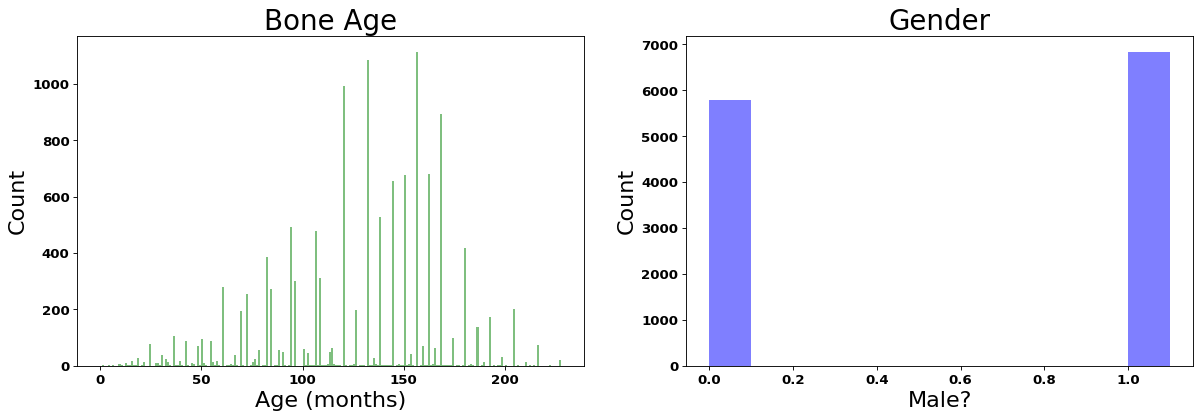

In [78]:
# Plot the total distribution for boneage and gender
import PlottingTools as pt

myFigure2 = plt.figure(figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k') 
myAxis1 = myFigure2.add_subplot(2,2,1)
myAxis2 = myFigure2.add_subplot(2,2,2)

myAxis1.hist(dataset['boneage'], 228, range = (0, 228.0), color='g', alpha=0.5)
myAxis2.hist(dataset['male'], 11, range = (0, 1.1), color='b', alpha=0.5)

#Title and stuff
pt.setTitle(myAxis1, 'Bone Age', 'Age (months)', 'Count')
pt.setTitle(myAxis2, 'Gender', 'Male?', 'Count')

#Ticks
pt.setTicks(myAxis1)
pt.setTicks(myAxis2)

print('Max, mean, and standard deviation of bone age is %d, %.2f, and %.2f months, respectively.' 
      %(dataset['boneage'].max(), dataset['boneage'].mean(), dataset['boneage'].std()))
print('Total number of male and female is %d (%.2f%%) and %d (%.2f%%), respectively.' 
      %(dataset[dataset['male']==1].shape[0], dataset[dataset['male']==1].shape[0]*100/dataset.shape[0],
        dataset[dataset['male']==0].shape[0], dataset[dataset['male']==0].shape[0]*100/dataset.shape[0]))

### Connect the x-ray images to the dataset

In [79]:
import os

dataset['image path'] = dataset['id'].map(lambda x: os.path.join('Input/boneage-dataset', '{}.png'.format(x)))

if dataset['image path'].map(os.path.exists).sum() != dataset.shape[0]:
    print('Warning!! Only', dataset['image path'].map(os.path.exists).sum(), 
          'x-ray images found out of', dataset.shape[0], 'total! \nWill continue with reduced dataset!!')
    dataset = dataset[dataset['image path'].map(os.path.exists)]
else:
    print('Awesome!! All ()',dataset['image path'].map(os.path.exists).sum(), 
          ') x-ray images found out of', dataset.shape[0], 'total!')

Warning!! Only 5358 x-ray images found out of 12611 total! 
Will continue with reduced dataset!!


### Preprocess the images for Keras

In [80]:
# The imageToTensor function takes a string-valued image path and returns 4D tensor

from keras.preprocessing import image                  
from tqdm import tqdm

def imageToTensor(imageToConvert):
    # Load the image as grayscale; wxh=224x224
    img = image.load_img(imageToConvert, grayscale=True, target_size=(224, 224))
    # Convert a PIL Image instance to a Numpy array with shape (224, 224, 1)
    x = image.img_to_array(img)
    # Convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

def imagesToTensor(imagesToConvert):
    listOfTensors = [imageToTensor(imageToConvert) for imageToConvert in tqdm(imagesToConvert)]
    return np.vstack(listOfTensors)

In [81]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True          

# Convert every x-ray images to 4D tensors
X = imagesToTensor(dataset['image path'])

# Rescale the images by dividing every pixel in every image by 255
# rescale [0,255] --> [0,1]
X = X.astype('float32')/255

100%|██████████| 5358/5358 [05:17<00:00, 16.86it/s]


In [82]:
from keras.utils import np_utils

# One-hot encode the labels
# Bone age in the sample is from 0 to 228 months
y = dataset['boneage']
y = np_utils.to_categorical(y, 229)

print('One-hot labels:')
print(y[:5])

One-hot labels:
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


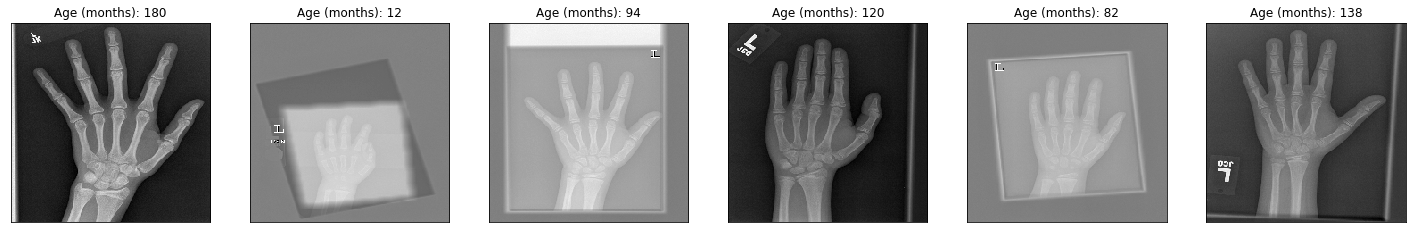

In [83]:
# Visualize the first six images

fig = plt.figure(figsize=(25,20))
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X[i]), cmap='gray')
    ax.set_title("Age (months): "+str(dataset['boneage'][i]))

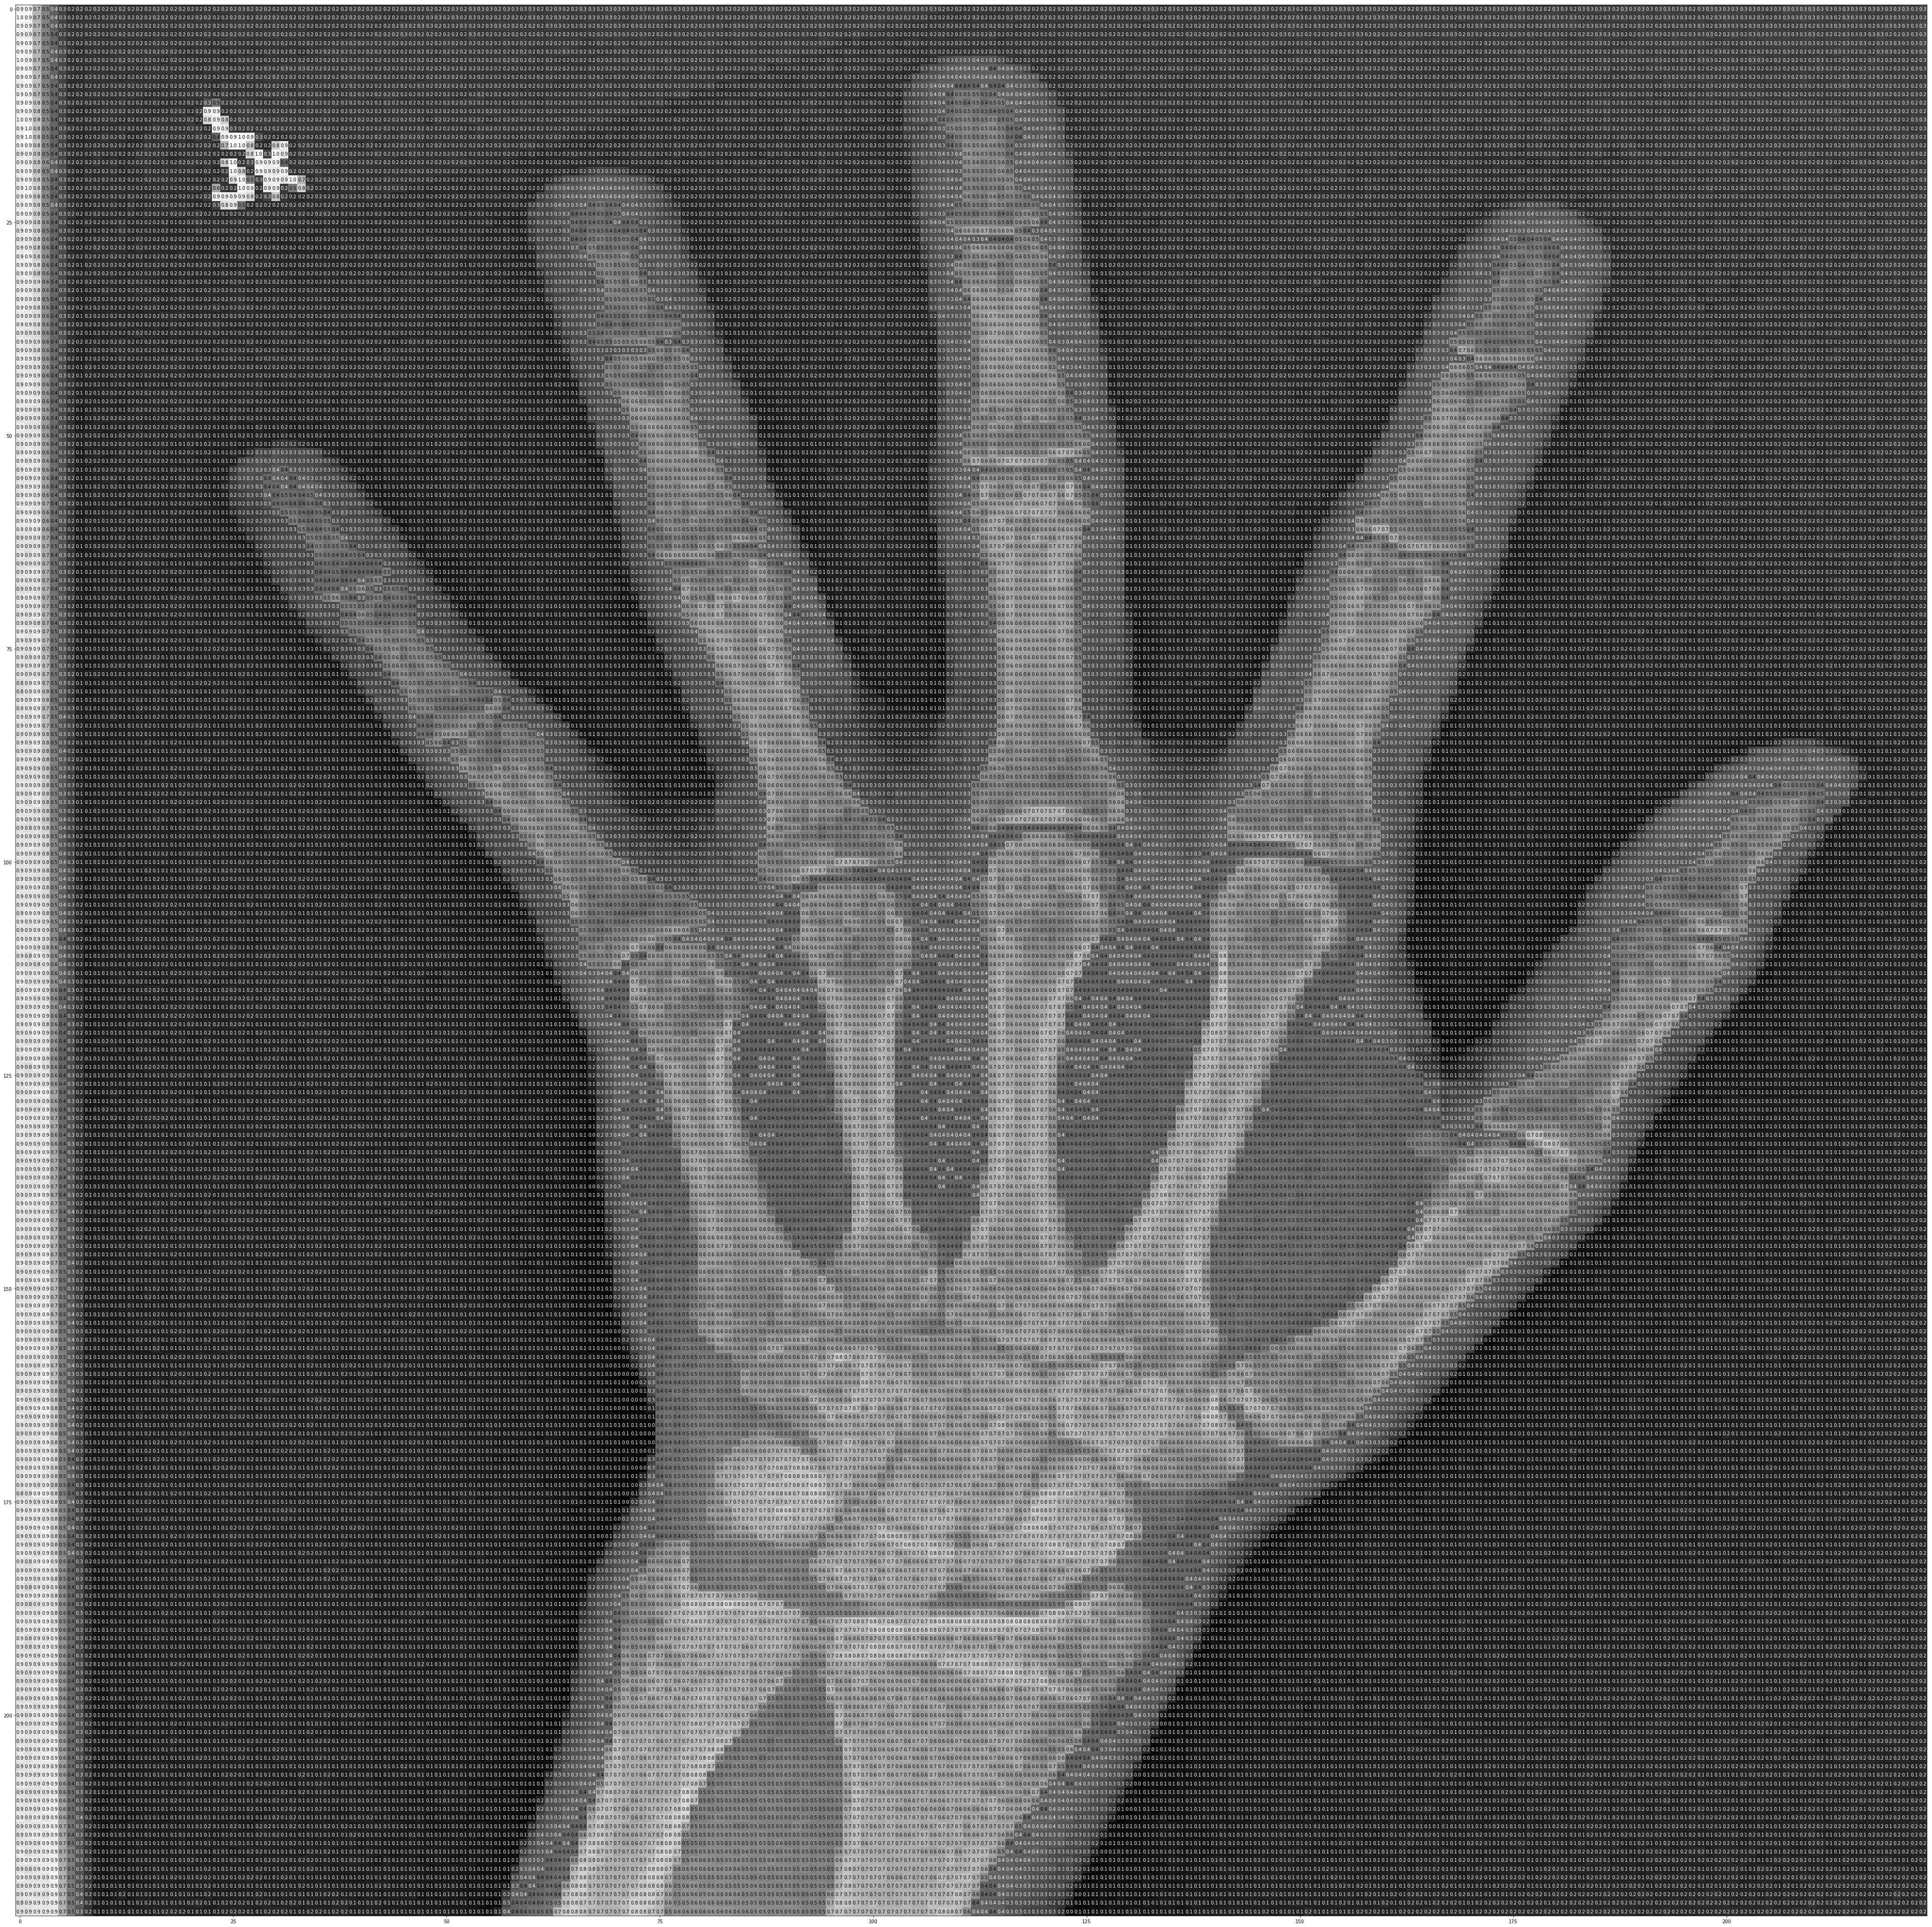

In [88]:
#Visualize a single image in detail

def visualizeImage(img, ax):
    ax.imshow(np.squeeze(img), cmap='gray')
    width, height, depth = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y][depth-1],1)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y][depth-1]<thresh else 'black')

fig = plt.figure(figsize = (75,75)) 
ax = fig.add_subplot(111)
visualizeImage(X[0], ax)

### Split data into training and testing sample

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=99)

print("The dataset has a training set of %d examples." % len(X_train))
print("The dataset has a test set of %d examples." % len(X_test))

The dataset has a training set of 4286 examples.
The dataset has a test set of 1072 examples.


### Define the Model Architecture

In [100]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

# Define the architecture.
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu',input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.25))

model.add(Flatten())         
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(229, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 224, 224, 32)      160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 74, 74, 64)        8256      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 24, 24, 128)       32896     
__________

### Compile the code

In [101]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Calculate the classification accuracy on the test set (before training)

In [102]:
# Evaluate the test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy (before training): %.4f%%' % accuracy)

Test accuracy: 0.0000%


### Train the model

In [103]:
from keras.callbacks import ModelCheckpoint   

# Train the model
checkpointer = ModelCheckpoint(filepath='SavedModels/BestFromScratch.hdf5', 
                               verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=128, epochs=10,
          validation_split=0.2, callbacks=[checkpointer],
          verbose=1, shuffle=True)

Train on 3428 samples, validate on 858 samples
Epoch 1/10
3428/3428 [==============================] - 166s - loss: 3.7944 - acc: 0.0723 - val_loss: 4.1363 - val_acc: 0.0536
Epoch 2/10
3428/3428 [==============================] - 129s - loss: 3.4519 - acc: 0.0828 - val_loss: 3.7035 - val_acc: 0.0932
Epoch 3/10
3428/3428 [==============================] - 114s - loss: 3.4086 - acc: 0.0893 - val_loss: 3.7424 - val_acc: 0.0851
Epoch 4/10
3428/3428 [==============================] - 116s - loss: 3.3761 - acc: 0.0980 - val_loss: 3.8744 - val_acc: 0.0781
Epoch 5/10
3428/3428 [==============================] - 112s - loss: 3.3261 - acc: 0.1053 - val_loss: 3.6610 - val_acc: 0.0944
Epoch 6/10
3428/3428 [==============================] - 105s - loss: 3.2814 - acc: 0.1158 - val_loss: 3.5385 - val_acc: 0.0793
Epoch 7/10
3428/3428 [==============================] - 108s - loss: 3.2122 - acc: 0.1222 - val_loss: 3.4702 - val_acc: 0.0956
Epoch 8/10
3428/3428 [==============================] - 110s - l

### Calculate the classification accuracy on the test set (after training)

In [105]:
# Load the model with the best classification accuracy on the validation set
model.load_weights('SavedModels/BestFromScratch.hdf5')

# Calculate the classification accuracy on the test set
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy (after training): %.4f%%' % accuracy)

Test accuracy: 8.5821%
